# Machine learning simple tutorial

## Example : building seismic damage prediction

Sophie Giffard-Roisin (sophie.giffard@univ-grenoble-alpes.fr)

## Introduction
This is a simple introduction to machine learning to get you to know how it works.

We will use a real building-damage dataset, which goal is to estimate the damage grade of a building from its features (construction material, number of floors, etc) and from the ground motion intensity. This dataset comes from the Nepal 2015 earthquake survey (thanks to Subash Ghimire and Philippe Gueguen for giving access to the data).



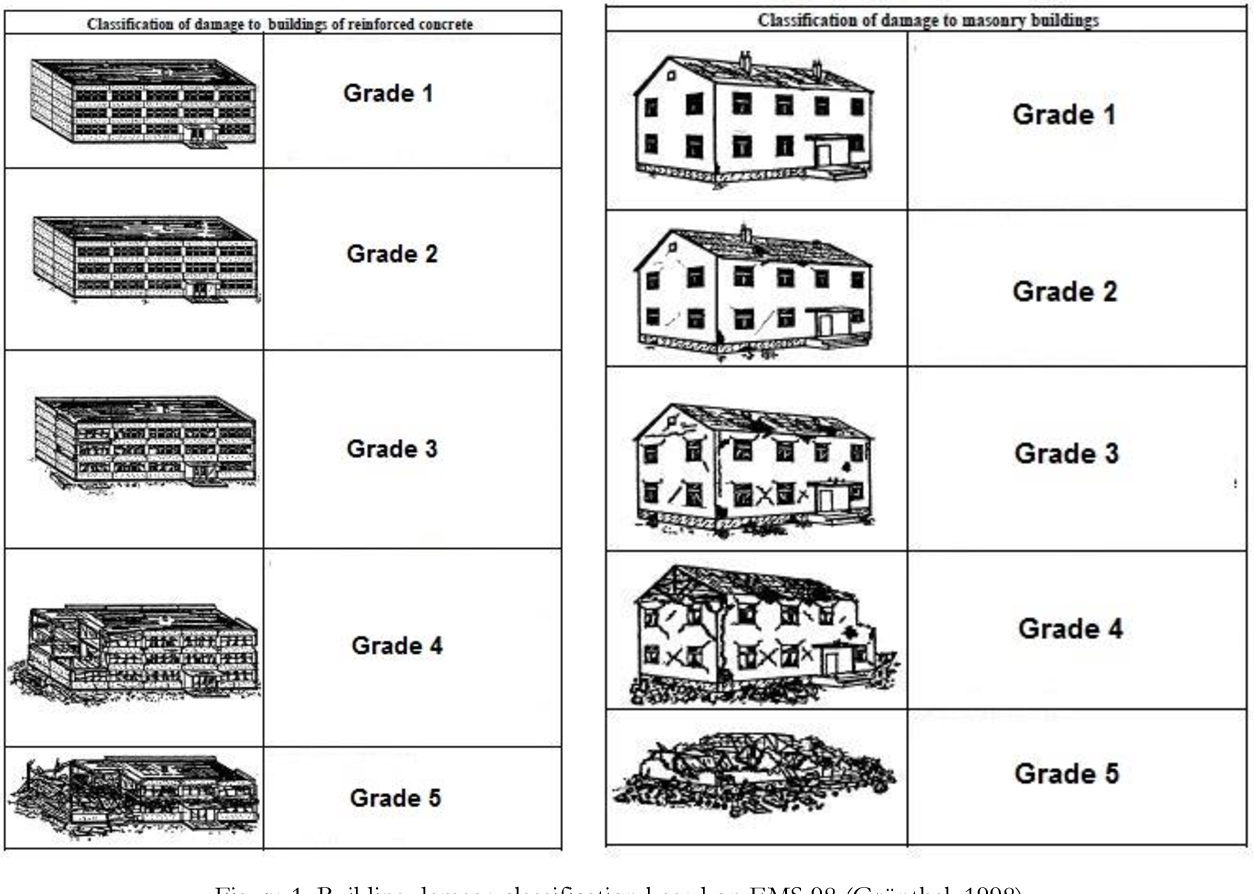

In [7]:
from IPython.display import display, Image
display(Image(filename='imgs/damage_grades.png', width='450px'))


<div style="text-align: center">Database target: building damage grades identified after the 2015 Nepal earthquake. Dataset input: building features (construction material, number of floors, etc) and the effective ground motion intensity at this location. (credits: Yalda Saedi)</div>

In [29]:
%matplotlib inline
import os
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## A. Loading the data

In [ ]:
train_filename = 'data/train_data_Nepal_damage.csv'
data = pd.read_csv(train_filename)
y = data['damage_grade']
print('The damage grades of the first 5 buildings of the dataset:')
y.head(5)

In [ ]:
X = data.drop(['damage_grade', 'building_id', 'district_id', 'ward_id', 'vdcmun_id', 'Unnamed: 0' , 'Unnamed: 22'], axis=1)
print('The corresponding features of the first 5 buildings of the dataset:')
X.head(5)

MSI is the macro-seismic intensity. Ask me if you want to know the meaning of the other columns=features.

Load also the test data (to validate our model in the end):

In [5]:
test_filename = 'data/test_data_Nepal_damage.csv'
data_test = pd.read_csv(test_filename)
y_test = data_test['damage_grade']
X_test = data_test.drop(['damage_grade', 'building_id', 'district_id', 'ward_id', 'vdcmun_id', 'Unnamed: 0' , 'Unnamed: 22'], axis=1)

How many features do we have (i.e. how many attributes does one sample have?) 
Tip: you can call 'X.columns' of the dataframe X.

In [ ]:
N_features = 
print('Number of features = ', N_features)
print('List of features = ', X.columns)

And how many samples (here buildings) do we have on the training set (and on the test set)? 
Tip: you can call 'X.index' of the dataframe X and then X_test.

In [ ]:
N_samples =
N_samples_test = 
print('Number of samples in training set: ', N_samples)
print('Number of samples in test set: ', N_samples_test)

## B. Check and Standardize your data

The input features are of different types.

**1) Continuous features**

'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 'MSI' are continuous values. In case there are missing values (such as NaN), it can be an easy check to look at the mean of these features to see if there is no problem and if the mean is coherent:

In [ ]:
print(np.mean(X['age_building']))
print(np.mean(X['plinth_area_sq_ft']))
print(np.mean(X['height_ft_pre_eq']))
print(np.mean(X['MSI']))

If there is no error or weird values, we can proceed. In case you need to replace some missing values, go to the end of the tutorial to see how do do.

**2) Categorical features**

'land_surface_condition', 'roof_type' and 'position' are categorical features, made of strings. We need first to transform these into integers.

In [7]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

cat_features = ['land_surface_condition','roof_type', 'position']

enc.fit(X[cat_features] )

X[cat_features] = enc.transform(X[cat_features])
X_test[cat_features] = enc.transform(X_test[cat_features])


Pay attention to:

- How the encoder works: First, the fitting phase, where we learn the link between strings and integers from the training dataset. Then, we apply the transformation to both datasets. These phases (fit, transform) will be similar in all of the transformations as well as in the learning algorithms, and sklearn is very easy to use as it keeps the same structure always.

- The fact that we always use the training dataset only to fit the transformations of the learning algorithms. The test set should be viewed as 'unseen' so not used to calculate anything. Yet, we also transform the test set as otherwise the training and test will be differenty processed.

- How the categorical features have been transformed by comparing the new values to the original strings on the first 5 samples:

In [ ]:
X.head(5)

**3) Binary features**

'has_superstructure_adobe_mud' and the following features are binary features: they are categorical features with only 2 categories and are already with 0 or 1, so we don't need to do anything.

**4) Rescale all the features**

In [8]:
from sklearn.preprocessing import StandardScaler

X = X.astype(float)
X_test = X_test.astype(float)

For all features, transform your data such that mean=0 and standard deviation std=1 (on the training data), and use the same parameters for transforming the test data also. Use the StandardScaler function and the fit / transform syntax.

In [ ]:

X =
X_test =

print(X)

As you see, the data is now an array (not a pandas dataframe anymore, just a simple 2D matrix). And the values have been modified. You can check, if you want, that every column has indeed a 0 mean and a 1 standard deviation (using np.mean() and np.std() functions).

## C. Visualization: principal component analysis

Use PCA method in order to visualize a lower sized representation of the data.

In [33]:
from sklearn.decomposition import PCA

1) Fit the pca with the training features using only the first 2 PCA components:

In [ ]:
pca = PCA(svd_solver='full', n_components=2)
pca.fit(X)

2) Create a reduced feature matrix X_pca (and then X_test_pca) using pca.transform 

In [35]:
X_pca = 
X_test_pca = 

We can now plot the first two modes of the X_pca, with y (=the damage grade) as color label.

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(np.transpose(X_pca)[0], np.transpose(X_pca)[1], c=y, s=1, cmap='jet')
plt.colorbar()

t = plt.suptitle('Projection on the 2 first PCA modes, color = y (damage grade of every building):')

Every point corresponds to one sample. The PCA does a projection of the feature space on the 2 axis of maximal variance. We can see that with only 2 axis, it is possible to roughly separate low damage grades from high damage grades, but a finer separation is impossible.

In [ ]:
plt.figure(figsize=(10,4))
plt.scatter(np.transpose(X_test_pca)[0], np.transpose(X_test_pca)[1], c=y_test, s=1, cmap='jet')
plt.colorbar()

t = plt.suptitle('Test set: Projection on the 2 first PCA modes, color = y (damage grade of every building):')

## D. Comparing different classifiers

Now we can train a machine learning model, and test it on the test dataset. For this, we will 'fit' the parameters of a machine learning technique during the fitting=training phase, where both X and y are known. Then, we will predict for every sample of the test set what is the estimated damage grade: we can then evaluate how good is our model by comparing with the ground thuth damage grade.

The classification consists in predicting a *class*, in opposition to a regression problem consisting in predicting a *continuous value*.

How many classes do we have in this problem? Tip: you can look at the np.unique() function.


In [ ]:
classes = 
print('classes: ', classes)
N_classes = 
print('number of classes: ', N_classes)

We will test different classification models:
* Nearest Neighbors
* Linear Support Vector Machine
* RBF Support Vector Machine
* Random Forests
* AdaBoost

For more information on them, I really encourage you to look at the sklearn documentation: https://scikit-learn.org

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Let us do it for one model, and then perform the same operations for the other models.

First, we initialize the instance of the classifier.

In [12]:
classifier_KNN = KNeighborsClassifier(3)

Then, we train the model, by giving to the model the features X and their associated target y of all training data.

In [ ]:
classifier_KNN.fit(X, y)

Finally, we can evaluate our model on unseen data, i.e. the test set. And compare the predictions with the ground truth y_test.

In [ ]:
y_predict_KNN = classifier_KNN.predict(X_test)
print('Damage grades predicted of the first 5 test samples: ', y_predict_KNN[0:5])
print('True damage grades of the first 5 test samples: ', np.array(y_test[0:5]))

 We can also calculate the score, i.e. the % of good predictions.

In [ ]:
from sklearn.metrics  import accuracy_score
score = accuracy_score(y_test, y_predict_KNN)
print(score)

Your turn! try to do the same with other classifiers: DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, QuadraticDiscriminantAnalysis, support vector classifier ('SVC', using either a linear kernel or an rbf kernel) for example. At first, use the default parameters, then, you can try to vary them by first looking at what they mean in the sklearn documentation.

## E. Visualizing the results: confusion matrix

We have now the score accuracy (percentage of correctly classified test samples), but can we understand better where are the errors? For this, a popular representation for classification problems is a *confusion matrix*. Let's see an example with the K-nearest neighbors classifier already trained.

In [19]:
import itertools

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(20, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return 0

In [ ]:
confusion_mat_KNN = confusion_matrix(y_test, y_predict_KNN)
plot_confusion_matrix(confusion_mat_KNN, classes=classes, normalize=True, title='Confusion matrix KNN (%)')

How to read such a table? Let's take an example. From the first value, we see that 61% of damage grade 1 (DG1) samples were correctly estimated as DG1. If we continue on this line, we can see that 19% of DG1 were wrongly predicted as DG2, 9% as DG3, etc. A perfect classifier would have ones in the diagonal, and zeros everywhere else.

And now, let's compute the confusion matrices for the other classifiers!

In [ ]:
confusion_mat_RandomForest = 

## F. What about regression?

Regression problem consists in estimating a continuous value, as opposed to *classes*: estimating the magnitude of an earthquake is a regression, while estimating the type of earthquakes (volcanic tectonic, tremor, etc) is a classification problem. Note that estimating a binary value is also a classification problem (such as *is this signal an earthquake or not?* there are two classes, 'yes' and 'no', i.e. 1 or 0).

In this problem, we could also view the damage grade as a regression problem. Why? because the damage grade is an *orderded* target, i.e. a DG1 is closer to a DG2 than a DG3, so an error from DG1 to DG2 is smaller than from DG1 to DG3. This is for example not the case for *unorderded* problems such as classifying images of cats vs. dogs vs. pigs.

The main difference in computation between regression and classification is the *loss*, i.e. the cost function that the algorithm will minimize between the training targets and the training predictions. In a regression, most often we minimize the mean squared error. This is the case in the linear regression, that you might already know:

In [ ]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()

linear_regressor.fit(X, y)
y_predict_lr = linear_regressor.predict(X_test)
print('Damage grades predicted of the first 5 test samples: ', y_predict_lr[0:5])
print('True damage grades of the first 5 test samples: ', np.array(y_test[0:5]))

Note how the predictions are now continuous values. And now, the results will not be percentage of correct classifications, but a distance (here in 'damage grade')!

In [ ]:
from sklearn.metrics  import mean_absolute_error
score = mean_absolute_error(y_test, y_predict_lr)
print('Linear regression: Mean absolute error (in DG): ', score)

Now train and estimate the mean error of more complex regressors, such as the RandomForestRegressor, Support Vector Regression (SVR), or the interesting automatic relevance determination (ARD)... you might need to look at sklearn documentation.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ARDRegression




## Side note: replacing missing values in a database

here is a code in case you need to replace whatever value (in this case, it was -9.223372036854776, but it can be zeros, or NaN, etc). 

In [ ]:
continuous_feats = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']

imp = SimpleImputer(missing_values=-9.223372036854776, strategy='mean')
X_train[continuous_feats].loc[:,:] = imp.fit_transform(X_train[continuous_feats].values)
#X_test[feat] = imp.transform(X_test[feat]) commented out

enc = OrdinalEncoder()
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)
